In [1]:
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,sklearn,pandas,scipy,matplotlib,statsmodels -g

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.18.1

numpy      : 1.19.2
sklearn    : 0.23.2
pandas     : 0.25.3
scipy      : 1.5.2
matplotlib : 3.3.2
statsmodels: 0.12.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit

Git hash: ed47513de7efcd2b95a54b9ac6695d1eff27af88



In [3]:
import os
import glob
import numpy as np
import pandas as pd

import re
#import random
import pickle

from tqdm.notebook import tqdm

from collections import Counter
from scipy.sparse import csr_matrix

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import plotly.graph_objects as go

In [4]:
PATH_TO_DATA     = os.path.join('.', 'data')
PATH_TO_DATA_ALL = os.path.join('.', 'data', 'allcats')
PATH_TO_DATA_OWN = os.path.join('.', 'data_own')
ANSW = os.path.join('.', 'answers')

Получаем список всех пользователей. он будет использоваться при формировании подвыборок.

In [5]:
filenames_all = [re.findall('\d+', x)[0] for x in sorted(glob.glob(PATH_TO_DATA_ALL + '/*.csv'))]
#filenames_10users_sub = [re.findall('\d+', x[-12:])[0] for x in sorted(glob.glob(os.path.join(PATH_TO_DATA, '10users') + '/*.csv'))]
#filenames_150users_sub = [re.findall('\d+', x[-12:])[0] for x in sorted(glob.glob(os.path.join(PATH_TO_DATA, '150users') + '/*.csv'))]

In [6]:
#Подготовим данные: разделим каждый файл на 3 колонки и пересохраним, что бы в дальнейшем читать только необходимые нам данные

In [7]:
def get_bootstrap_samples(data, n_samples, n_users = 10, random_seed=42):
    
    np.random.seed(random_seed)
    
    if n_users > 501:
        random_seed = 9999
        np.random.seed(random_seed)
        return np.random.randint(0, len(data), (1, n_users))
    else:    
        return np.random.randint(0, len(data), (n_samples, n_users))


In [8]:
def create_load_freq_site_dict(files, users_count, indexes = []):
    
    if users_count > 1000000:
        outp_freq_site_dict = pickle.load(open(os.path.join(PATH_TO_DATA_OWN, f'freq_site_dict_{users_count}users.pkl'), 'rb'))
    else:
        outp_freq_site_dict = dict()
        site_cnt = Counter()
        
        for idx in tqdm(indexes):
            temp_dataframe = pd.read_csv(os.path.join(PATH_TO_DATA_ALL, f'cat{files[idx]}.csv'), header = None, sep= ';')#, parse_dates=[1]))
            temp_dataframe.columns = ['target', 'timestamp', 'site']
            site_cnt += Counter(temp_dataframe.site.values)
            #rows += round(temp_dataframe.shape[0] / sess_len + 0.499)

        #rows = rows

        for idx, site_dict in enumerate(site_cnt.most_common(), start = 1):
            outp_freq_site_dict[site_dict[0]] = (idx, site_dict[1])    
    
    return outp_freq_site_dict

Создаем словарь из всех сайтов с номером сайта, соответствующим его частоте. Это будут признаки.

In [30]:
%%time
#users = 100
#idxs = get_bootstrap_samples(file_names_all, 1, users)
#idxs = get_bootstrap_samples(filenames_all, 1, len(filenames_all))
#freq_site = create_load_freq_site_dict(file_names_all, users, idxs[0])
#freq_site = create_load_freq_site_dict(filenames_all, len(filenames_all), idxs[0])

if not os.path.isfile(os.path.join(PATH_TO_DATA_OWN, 'site_freq_full_data.pkl')):
    freq_site = create_load_freq_site_dict(filenames_all, len(filenames_all), range(len(filenames_all)))
    pickle.dump(freq_site, open(os.path.join(PATH_TO_DATA_OWN, 'site_freq_full_data.pkl'), 'wb'))
    print(len(freq_site))

Wall time: 0 ns


In [9]:
def prepare_sparse_train_set_window(inp_fnames, inp_idexes, inp_sess_len, inp_wind_size):
    
    #rows = 0
    #site_cnt = []
    ret_userid_list = []
    # form dataframe names ['site1, site2......site{session_length}']
    col_names = ['site' + str(n+1) for n in range(inp_sess_len)]

    pkl_name = os.path.join(PATH_TO_DATA_OWN, 'site_freq_full_data.pkl')
    #with open(path_to_site_freq, 'rb') as f:
    with open(pkl_name, 'rb') as f:
        freq_site_dict = pickle.load(f)

    row_csr  = []
    col_csr  = []
    data_csr = []
        
    # getting size of DataFrame
    # collect all sites ans them frequencies
    #for file_csv in (sorted(glob.glob(path_to_csv + '/*.csv'))):
    #    temp_dataframe = pd.read_csv(file_csv, usecols=['site'])
    #    site_cnt += list(temp_dataframe.site.values)
    #    rows += round(temp_dataframe.shape[0] / inp_wind_size + 0.499)

    #site_cnt = Counter(site_cnt)

    # ceate DataFrame of known size
    #ret_data = pd.DataFrame(index = range(rows), columns = col_names)
    index = 0


    #for file_csv in (sorted(glob.glob(path_to_csv + '/*.csv'))):
    #for idx in tqdm(inp_idexes):
    for idx in (inp_idexes):
            temp_dataframe = pd.read_csv(os.path.join(PATH_TO_DATA_ALL, f'cat{inp_fnames[idx]}.csv'), header = None, sep= ';')#, parse_dates=[1]))
            temp_dataframe.columns = ['target', 'timestamp', 'site']
            #temp_dataframe = pd.read_csv(file_csv, usecols=['site'])
            #userid = int(re.findall('\d+', file_csv)[1])
            userid = inp_fnames[idx]


            sess_numb = round(temp_dataframe.shape[0] / inp_wind_size + 0.499)
            for idx in range(sess_numb - 1):
                #new dict for current session
                new_sess = {('site' + str(n+1)):0 for n in range(inp_sess_len)}

                sess_start = idx*inp_wind_size
                sess_end   = idx*inp_wind_size + inp_sess_len

                for n, site in enumerate(temp_dataframe.site.values[sess_start : sess_end]):
                    new_sess['site' + str(n+1)] = freq_site_dict[site][0]
                #new_sess['user_id'] = userid
                ret_userid_list.append(userid)
                
                cnt_csr = Counter(new_sess.values())
                row_csr += [index] * len(cnt_csr)     # row number in which value is parse
                data_csr+= list(cnt_csr.values())   # value
                col_csr += list(cnt_csr.keys())     # column number in which value is parse
                index += 1


            new_sess = {('site' + str(n+1)):0 for n in range(inp_sess_len)}
            for n, site in enumerate(temp_dataframe.site.values[(sess_numb-1)*inp_wind_size: ]):
                new_sess['site' + str(n+1)] = freq_site_dict[site][0]
            ret_userid_list.append(userid)
            cnt_csr = Counter(new_sess.values())
            row_csr += [index] * len(cnt_csr)     # row number in which value is parse
            data_csr+= list(cnt_csr.values())   # value
            col_csr += list(cnt_csr.keys())     # column number in which value is parse
                
            index += 1

    
    ret_csr = csr_matrix((data_csr, (row_csr, col_csr)), shape = (max(row_csr)+1, max(col_csr)+1))[:, 1:]
    
    return ret_csr, np.array(ret_userid_list)


Сформируем параметры для сбора статистик

In [10]:
variant_nusers = [ 2,   5,   10, 50, 100, 500, 1000, 2000, len(filenames_all)]
variant_naver  = [100, 100, 100, 50, 10,   5,   1,    1,    1]
len(variant_nusers) == len(variant_naver)

True

In [ ]:
#for params in tqdm(zip(variant_naver, variant_nusers)):
#    print(params[0], params[1])

Рассчитаем точность по выбранным параметрам

In [12]:
%%time

sess_len  = 10
wind_size = 10

full_acc = []

#for params in tqdm(zip(variant_naver, variant_nusers)):
#    indexes = get_bootstrap_samples(filenames_all, params[0], params[1])
for params in tqdm(variant_nusers):
    if params > 501:
        n_aver = 1
    else:
        n_aver = 10
    indexes = get_bootstrap_samples(filenames_all, n_aver, params)


    acc = []
    for idx in indexes:
        train_data_sparse, targets = prepare_sparse_train_set_window(filenames_all, idx, sess_len, wind_size)

        try:
            X_train, X_valid, y_train, y_valid = train_test_split(train_data_sparse, targets, 
                                                      test_size=0.3, 
                                                      random_state=821, stratify=targets)
        except ValueError:
            X_train, X_valid, y_train, y_valid = train_test_split(train_data_sparse, targets, 
                                                      test_size=0.3, 
                                                      random_state=821)

        clf = SGDClassifier(loss = 'log', n_jobs = -1, )
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_valid)
        #roc_auc_score(y_valid, y_pred)
        acc.append(accuracy_score(y_valid, y_pred))
    full_acc.append(acc)


Wall time: 7min 54s


Посмотрим на ожидаемую точность (accuracy)

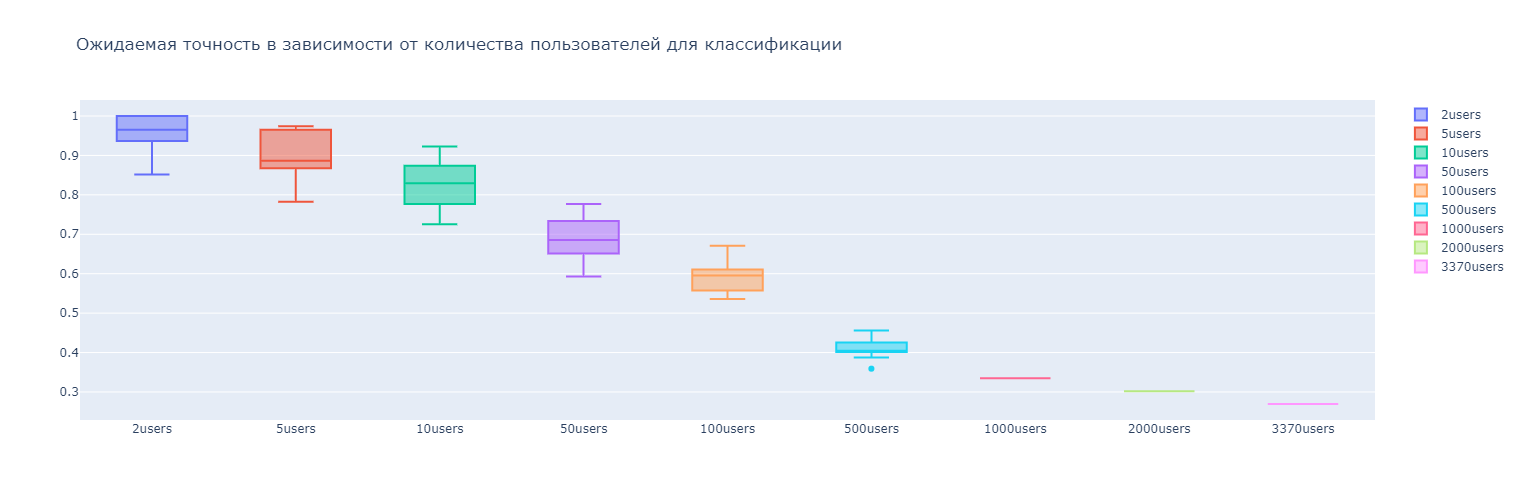

In [31]:
fig = go.Figure()
lin_acc = []
x_names = [str(el) + 'users' for el in variant_nusers]
for idx, el in enumerate(full_acc):
    lin_acc.append(np.mean(el))
    fig.add_trace(go.Box(y=el, name = x_names[idx]))
    
#fig.add_trace(go.Scatter(y=lin_acc, x = x_names))
fig.update_layout(
    autosize=False,
    width=900,
    height=500, 
    title = f'Ожидаемая точность в зависимости от количества пользователей для классификации')

fig.show()